<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[10:03:36] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


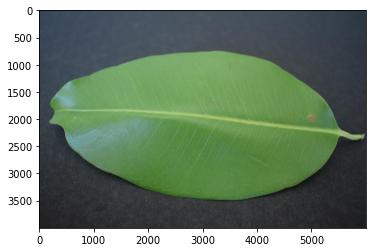

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

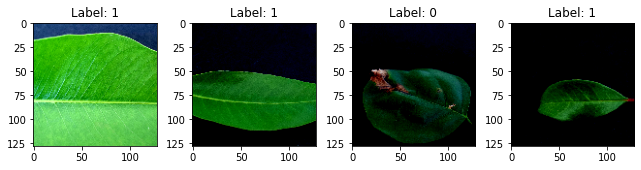

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[10:03:43] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[10:03:45] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2638248888715462 samples/sec                   batch loss = 0.889775276184082 | accuracy = 0.4


Epoch[1] Batch[10] Speed: 1.2653775674532517 samples/sec                   batch loss = 0.40599000453948975 | accuracy = 0.55


Epoch[1] Batch[15] Speed: 1.2675148740505944 samples/sec                   batch loss = 1.537177324295044 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.2687012106083442 samples/sec                   batch loss = 0.761067807674408 | accuracy = 0.55


Epoch[1] Batch[25] Speed: 1.2652731671271829 samples/sec                   batch loss = 0.3189447820186615 | accuracy = 0.61


Epoch[1] Batch[30] Speed: 1.2686752114551192 samples/sec                   batch loss = 0.517871081829071 | accuracy = 0.625


Epoch[1] Batch[35] Speed: 1.2696635446276412 samples/sec                   batch loss = 0.7012754082679749 | accuracy = 0.6214285714285714


Epoch[1] Batch[40] Speed: 1.2703368836736364 samples/sec                   batch loss = 0.34872254729270935 | accuracy = 0.63125


Epoch[1] Batch[45] Speed: 1.2643881746070684 samples/sec                   batch loss = 0.4076107442378998 | accuracy = 0.6555555555555556


Epoch[1] Batch[50] Speed: 1.2672590537382074 samples/sec                   batch loss = 1.7687122821807861 | accuracy = 0.64


Epoch[1] Batch[55] Speed: 1.2722647059113479 samples/sec                   batch loss = 0.9630823135375977 | accuracy = 0.6272727272727273


Epoch[1] Batch[60] Speed: 1.272721893553967 samples/sec                   batch loss = 0.6721600890159607 | accuracy = 0.6375


Epoch[1] Batch[65] Speed: 1.2687906328050567 samples/sec                   batch loss = 1.6914865970611572 | accuracy = 0.6538461538461539


Epoch[1] Batch[70] Speed: 1.2710235513230232 samples/sec                   batch loss = 0.7518176436424255 | accuracy = 0.6607142857142857


Epoch[1] Batch[75] Speed: 1.2698326774596136 samples/sec                   batch loss = 0.5863564014434814 | accuracy = 0.6633333333333333


Epoch[1] Batch[80] Speed: 1.269171777922838 samples/sec                   batch loss = 0.8635780811309814 | accuracy = 0.671875


Epoch[1] Batch[85] Speed: 1.2658636278685 samples/sec                   batch loss = 0.563389003276825 | accuracy = 0.6735294117647059


Epoch[1] Batch[90] Speed: 1.2693364581240119 samples/sec                   batch loss = 0.5940129160881042 | accuracy = 0.6666666666666666


Epoch[1] Batch[95] Speed: 1.2689838162587734 samples/sec                   batch loss = 0.9818704128265381 | accuracy = 0.6578947368421053


Epoch[1] Batch[100] Speed: 1.2727777977973043 samples/sec                   batch loss = 0.4019237458705902 | accuracy = 0.6575


Epoch[1] Batch[105] Speed: 1.265993154202048 samples/sec                   batch loss = 1.2724812030792236 | accuracy = 0.6571428571428571


Epoch[1] Batch[110] Speed: 1.2695348032465832 samples/sec                   batch loss = 0.7276389598846436 | accuracy = 0.6568181818181819


Epoch[1] Batch[115] Speed: 1.2712242541949026 samples/sec                   batch loss = 0.548417866230011 | accuracy = 0.6630434782608695


Epoch[1] Batch[120] Speed: 1.271018062739468 samples/sec                   batch loss = 2.3880603313446045 | accuracy = 0.6625


Epoch[1] Batch[125] Speed: 1.2651216550718154 samples/sec                   batch loss = 0.40159595012664795 | accuracy = 0.668


Epoch[1] Batch[130] Speed: 1.268927189082995 samples/sec                   batch loss = 1.182932734489441 | accuracy = 0.6615384615384615


Epoch[1] Batch[135] Speed: 1.2613543359371064 samples/sec                   batch loss = 0.6958696246147156 | accuracy = 0.662962962962963


Epoch[1] Batch[140] Speed: 1.2663159390796432 samples/sec                   batch loss = 0.7281749248504639 | accuracy = 0.6678571428571428


Epoch[1] Batch[145] Speed: 1.2662643283130477 samples/sec                   batch loss = 0.45744818449020386 | accuracy = 0.6655172413793103


Epoch[1] Batch[150] Speed: 1.2692938196165824 samples/sec                   batch loss = 0.5208505392074585 | accuracy = 0.6666666666666666


Epoch[1] Batch[155] Speed: 1.2683911130451784 samples/sec                   batch loss = 0.7559999823570251 | accuracy = 0.667741935483871


Epoch[1] Batch[160] Speed: 1.2654689080095072 samples/sec                   batch loss = 0.7138585448265076 | accuracy = 0.66875


Epoch[1] Batch[165] Speed: 1.2676445469810131 samples/sec                   batch loss = 0.5600840449333191 | accuracy = 0.6681818181818182


Epoch[1] Batch[170] Speed: 1.2670343387788852 samples/sec                   batch loss = 0.4702187180519104 | accuracy = 0.6705882352941176


Epoch[1] Batch[175] Speed: 1.2699842626018407 samples/sec                   batch loss = 0.732961893081665 | accuracy = 0.6714285714285714


Epoch[1] Batch[180] Speed: 1.2668849876250559 samples/sec                   batch loss = 1.0450575351715088 | accuracy = 0.6694444444444444


Epoch[1] Batch[185] Speed: 1.268012065799131 samples/sec                   batch loss = 1.074523687362671 | accuracy = 0.6716216216216216


Epoch[1] Batch[190] Speed: 1.270094826267921 samples/sec                   batch loss = 0.8489995002746582 | accuracy = 0.6697368421052632


Epoch[1] Batch[195] Speed: 1.2696750749803973 samples/sec                   batch loss = 0.5520765781402588 | accuracy = 0.6717948717948717


Epoch[1] Batch[200] Speed: 1.2679875323596426 samples/sec                   batch loss = 0.5742900967597961 | accuracy = 0.67375


Epoch[1] Batch[205] Speed: 1.2655003123543735 samples/sec                   batch loss = 0.438128262758255 | accuracy = 0.675609756097561


Epoch[1] Batch[210] Speed: 1.2693450053766968 samples/sec                   batch loss = 0.41270196437835693 | accuracy = 0.6797619047619048


Epoch[1] Batch[215] Speed: 1.261766894632126 samples/sec                   batch loss = 0.4935993552207947 | accuracy = 0.6825581395348838


Epoch[1] Batch[220] Speed: 1.2656267091247515 samples/sec                   batch loss = 0.6840659379959106 | accuracy = 0.6818181818181818


Epoch[1] Batch[225] Speed: 1.2734394628017311 samples/sec                   batch loss = 0.9064446687698364 | accuracy = 0.6788888888888889


Epoch[1] Batch[230] Speed: 1.2684361843130403 samples/sec                   batch loss = 0.5585900545120239 | accuracy = 0.6760869565217391


Epoch[1] Batch[235] Speed: 1.262650310800492 samples/sec                   batch loss = 0.6460500955581665 | accuracy = 0.674468085106383


Epoch[1] Batch[240] Speed: 1.2666700641405315 samples/sec                   batch loss = 0.33785679936408997 | accuracy = 0.6760416666666667


Epoch[1] Batch[245] Speed: 1.264033514652037 samples/sec                   batch loss = 0.6302890181541443 | accuracy = 0.6744897959183673


Epoch[1] Batch[250] Speed: 1.2697875068958708 samples/sec                   batch loss = 0.2614307701587677 | accuracy = 0.677


Epoch[1] Batch[255] Speed: 1.2725666619285148 samples/sec                   batch loss = 0.5188185572624207 | accuracy = 0.6794117647058824


Epoch[1] Batch[260] Speed: 1.2628230932346913 samples/sec                   batch loss = 0.46407443284988403 | accuracy = 0.6798076923076923


Epoch[1] Batch[265] Speed: 1.2670230477111826 samples/sec                   batch loss = 0.46828415989875793 | accuracy = 0.6830188679245283


Epoch[1] Batch[270] Speed: 1.2744761873073773 samples/sec                   batch loss = 0.7103493213653564 | accuracy = 0.687037037037037


Epoch[1] Batch[275] Speed: 1.2679191120795987 samples/sec                   batch loss = 0.8126475811004639 | accuracy = 0.6872727272727273


Epoch[1] Batch[280] Speed: 1.2713937067693246 samples/sec                   batch loss = 0.37271934747695923 | accuracy = 0.6883928571428571


Epoch[1] Batch[285] Speed: 1.2714003547780455 samples/sec                   batch loss = 1.0198808908462524 | accuracy = 0.6842105263157895


Epoch[1] Batch[290] Speed: 1.2623399344301964 samples/sec                   batch loss = 0.5097988843917847 | accuracy = 0.6836206896551724


Epoch[1] Batch[295] Speed: 1.266767999754759 samples/sec                   batch loss = 0.4156450033187866 | accuracy = 0.6855932203389831


Epoch[1] Batch[300] Speed: 1.2695697722030532 samples/sec                   batch loss = 0.7743560671806335 | accuracy = 0.685


Epoch[1] Batch[305] Speed: 1.2724901219646776 samples/sec                   batch loss = 0.5508230924606323 | accuracy = 0.6868852459016394


Epoch[1] Batch[310] Speed: 1.2703145686025017 samples/sec                   batch loss = 0.7419155240058899 | accuracy = 0.6854838709677419


Epoch[1] Batch[315] Speed: 1.264468698603593 samples/sec                   batch loss = 0.37382784485816956 | accuracy = 0.6888888888888889


Epoch[1] Batch[320] Speed: 1.26531820793367 samples/sec                   batch loss = 0.3247593641281128 | accuracy = 0.690625


Epoch[1] Batch[325] Speed: 1.2639077215352654 samples/sec                   batch loss = 0.4498884081840515 | accuracy = 0.6907692307692308


Epoch[1] Batch[330] Speed: 1.2683449902340886 samples/sec                   batch loss = 0.5244467854499817 | accuracy = 0.6924242424242424


Epoch[1] Batch[335] Speed: 1.2659409966057644 samples/sec                   batch loss = 0.4120420515537262 | accuracy = 0.6925373134328359


Epoch[1] Batch[340] Speed: 1.2720640601908975 samples/sec                   batch loss = 0.47516727447509766 | accuracy = 0.6948529411764706


Epoch[1] Batch[345] Speed: 1.2701253067676133 samples/sec                   batch loss = 1.0817242860794067 | accuracy = 0.6956521739130435


Epoch[1] Batch[350] Speed: 1.2627046684925485 samples/sec                   batch loss = 0.7749587893486023 | accuracy = 0.6935714285714286


Epoch[1] Batch[355] Speed: 1.2686475825266292 samples/sec                   batch loss = 0.8370028734207153 | accuracy = 0.6936619718309859


Epoch[1] Batch[360] Speed: 1.2689966780504522 samples/sec                   batch loss = 0.5657625198364258 | accuracy = 0.6923611111111111


Epoch[1] Batch[365] Speed: 1.2694085851833923 samples/sec                   batch loss = 0.42612871527671814 | accuracy = 0.6917808219178082


Epoch[1] Batch[370] Speed: 1.2623864764084547 samples/sec                   batch loss = 0.3859204649925232 | accuracy = 0.6918918918918919


Epoch[1] Batch[375] Speed: 1.2714107604964873 samples/sec                   batch loss = 0.41542595624923706 | accuracy = 0.6933333333333334


Epoch[1] Batch[380] Speed: 1.2722534179095062 samples/sec                   batch loss = 0.6852294206619263 | accuracy = 0.6907894736842105


Epoch[1] Batch[385] Speed: 1.2730107367212926 samples/sec                   batch loss = 0.8160079121589661 | accuracy = 0.688961038961039


Epoch[1] Batch[390] Speed: 1.265274216770501 samples/sec                   batch loss = 0.2962671220302582 | accuracy = 0.691025641025641


Epoch[1] Batch[395] Speed: 1.2685255691525048 samples/sec                   batch loss = 0.2762308418750763 | accuracy = 0.6905063291139241


Epoch[1] Batch[400] Speed: 1.2682674232580333 samples/sec                   batch loss = 0.4751701354980469 | accuracy = 0.691875


Epoch[1] Batch[405] Speed: 1.2630254931830098 samples/sec                   batch loss = 0.7926841378211975 | accuracy = 0.6919753086419753


Epoch[1] Batch[410] Speed: 1.2713264598071794 samples/sec                   batch loss = 0.6370266079902649 | accuracy = 0.6926829268292682


Epoch[1] Batch[415] Speed: 1.2728188359892725 samples/sec                   batch loss = 0.39010298252105713 | accuracy = 0.694578313253012


Epoch[1] Batch[420] Speed: 1.2720172841093673 samples/sec                   batch loss = 0.5681897401809692 | accuracy = 0.6946428571428571


Epoch[1] Batch[425] Speed: 1.272341122268231 samples/sec                   batch loss = 0.7411154508590698 | accuracy = 0.6941176470588235


Epoch[1] Batch[430] Speed: 1.267222871926484 samples/sec                   batch loss = 0.570163369178772 | accuracy = 0.6947674418604651


Epoch[1] Batch[435] Speed: 1.2723866676950593 samples/sec                   batch loss = 0.6541917324066162 | accuracy = 0.6931034482758621


Epoch[1] Batch[440] Speed: 1.2636822897926563 samples/sec                   batch loss = 0.09814159572124481 | accuracy = 0.6948863636363637


Epoch[1] Batch[445] Speed: 1.2679134586332406 samples/sec                   batch loss = 0.5105628371238708 | accuracy = 0.6949438202247191


Epoch[1] Batch[450] Speed: 1.2712575824003296 samples/sec                   batch loss = 0.5813527703285217 | accuracy = 0.6955555555555556


Epoch[1] Batch[455] Speed: 1.2679195911875396 samples/sec                   batch loss = 0.6092910766601562 | accuracy = 0.6961538461538461


Epoch[1] Batch[460] Speed: 1.263671248749771 samples/sec                   batch loss = 0.24804627895355225 | accuracy = 0.6972826086956522


Epoch[1] Batch[465] Speed: 1.268970090902985 samples/sec                   batch loss = 0.9394611120223999 | accuracy = 0.6967741935483871


Epoch[1] Batch[470] Speed: 1.2692127759369374 samples/sec                   batch loss = 0.43847447633743286 | accuracy = 0.698936170212766


Epoch[1] Batch[475] Speed: 1.2731891684163907 samples/sec                   batch loss = 0.3583407402038574 | accuracy = 0.7010526315789474


Epoch[1] Batch[480] Speed: 1.2698908272781482 samples/sec                   batch loss = 0.6461475491523743 | accuracy = 0.7005208333333334


Epoch[1] Batch[485] Speed: 1.265813773026374 samples/sec                   batch loss = 0.3028774857521057 | accuracy = 0.6994845360824742


Epoch[1] Batch[490] Speed: 1.269296124327532 samples/sec                   batch loss = 0.08468253910541534 | accuracy = 0.7


Epoch[1] Batch[495] Speed: 1.26585321724182 samples/sec                   batch loss = 0.44722089171409607 | accuracy = 0.6984848484848485


Epoch[1] Batch[500] Speed: 1.2650244507672652 samples/sec                   batch loss = 1.1014742851257324 | accuracy = 0.6985


Epoch[1] Batch[505] Speed: 1.27040200584179 samples/sec                   batch loss = 0.15740527212619781 | accuracy = 0.6975247524752475


Epoch[1] Batch[510] Speed: 1.2723272277023865 samples/sec                   batch loss = 0.3252463638782501 | accuracy = 0.7


Epoch[1] Batch[515] Speed: 1.2599508702838815 samples/sec                   batch loss = 0.4298304617404938 | accuracy = 0.7


Epoch[1] Batch[520] Speed: 1.2714229007166165 samples/sec                   batch loss = 0.062202345579862595 | accuracy = 0.7


Epoch[1] Batch[525] Speed: 1.2683955241342464 samples/sec                   batch loss = 0.5494859218597412 | accuracy = 0.6995238095238095


Epoch[1] Batch[530] Speed: 1.2652933014981582 samples/sec                   batch loss = 0.5328630208969116 | accuracy = 0.6985849056603773


Epoch[1] Batch[535] Speed: 1.2704255745938147 samples/sec                   batch loss = 0.36171630024909973 | accuracy = 0.6985981308411215


Epoch[1] Batch[540] Speed: 1.2694875405756727 samples/sec                   batch loss = 0.443041056394577 | accuracy = 0.6990740740740741


Epoch[1] Batch[545] Speed: 1.2710437728293629 samples/sec                   batch loss = 0.20344620943069458 | accuracy = 0.7004587155963303


Epoch[1] Batch[550] Speed: 1.2654621309845435 samples/sec                   batch loss = 0.4806268811225891 | accuracy = 0.7004545454545454


Epoch[1] Batch[555] Speed: 1.269716105517446 samples/sec                   batch loss = 0.44851434230804443 | accuracy = 0.7009009009009008


Epoch[1] Batch[560] Speed: 1.2652412015511505 samples/sec                   batch loss = 0.7468457221984863 | accuracy = 0.6995535714285714


Epoch[1] Batch[565] Speed: 1.2704173013812514 samples/sec                   batch loss = 0.12364175915718079 | accuracy = 0.7008849557522124


Epoch[1] Batch[570] Speed: 1.2643540622079512 samples/sec                   batch loss = 0.3796389400959015 | accuracy = 0.7013157894736842


Epoch[1] Batch[575] Speed: 1.2649842951548793 samples/sec                   batch loss = 0.2512674927711487 | accuracy = 0.7008695652173913


Epoch[1] Batch[580] Speed: 1.268653914049785 samples/sec                   batch loss = 0.37724509835243225 | accuracy = 0.7


Epoch[1] Batch[585] Speed: 1.264373023900917 samples/sec                   batch loss = 0.374435156583786 | accuracy = 0.7004273504273504


Epoch[1] Batch[590] Speed: 1.2678618133810333 samples/sec                   batch loss = 0.5305171012878418 | accuracy = 0.7016949152542373


Epoch[1] Batch[595] Speed: 1.2726599122067883 samples/sec                   batch loss = 0.8096176385879517 | accuracy = 0.7


Epoch[1] Batch[600] Speed: 1.2727837843804426 samples/sec                   batch loss = 0.16442234814167023 | accuracy = 0.7008333333333333


Epoch[1] Batch[605] Speed: 1.268359373287185 samples/sec                   batch loss = 0.30106890201568604 | accuracy = 0.7008264462809918


Epoch[1] Batch[610] Speed: 1.2710699654511615 samples/sec                   batch loss = 0.5378270745277405 | accuracy = 0.7012295081967214


Epoch[1] Batch[615] Speed: 1.2719746581815872 samples/sec                   batch loss = 0.2666424512863159 | accuracy = 0.7012195121951219


Epoch[1] Batch[620] Speed: 1.2693786192846068 samples/sec                   batch loss = 0.744991660118103 | accuracy = 0.7004032258064516


Epoch[1] Batch[625] Speed: 1.2697785692715575 samples/sec                   batch loss = 0.3546883463859558 | accuracy = 0.7012


Epoch[1] Batch[630] Speed: 1.2679484341525906 samples/sec                   batch loss = 0.23790967464447021 | accuracy = 0.7007936507936507


Epoch[1] Batch[635] Speed: 1.2686865319886453 samples/sec                   batch loss = 0.5031290650367737 | accuracy = 0.7007874015748031


Epoch[1] Batch[640] Speed: 1.2715819975654032 samples/sec                   batch loss = 0.42833957076072693 | accuracy = 0.701171875


Epoch[1] Batch[645] Speed: 1.2671038119795317 samples/sec                   batch loss = 0.43643128871917725 | accuracy = 0.7015503875968992


Epoch[1] Batch[650] Speed: 1.2680569184474624 samples/sec                   batch loss = 0.9591179490089417 | accuracy = 0.7023076923076923


Epoch[1] Batch[655] Speed: 1.2738188608408205 samples/sec                   batch loss = 0.3600862920284271 | accuracy = 0.7041984732824428


Epoch[1] Batch[660] Speed: 1.2727285554599292 samples/sec                   batch loss = 0.5196921825408936 | accuracy = 0.7049242424242425


Epoch[1] Batch[665] Speed: 1.266210714916445 samples/sec                   batch loss = 0.2830425798892975 | accuracy = 0.7045112781954888


Epoch[1] Batch[670] Speed: 1.2675929236329107 samples/sec                   batch loss = 0.4965248703956604 | accuracy = 0.7044776119402985


Epoch[1] Batch[675] Speed: 1.2682350186044968 samples/sec                   batch loss = 1.310949683189392 | accuracy = 0.7044444444444444


Epoch[1] Batch[680] Speed: 1.266249419319244 samples/sec                   batch loss = 0.4359651803970337 | accuracy = 0.7047794117647059


Epoch[1] Batch[685] Speed: 1.27026061169185 samples/sec                   batch loss = 0.4187283515930176 | accuracy = 0.7054744525547445


Epoch[1] Batch[690] Speed: 1.269543064969091 samples/sec                   batch loss = 0.25657662749290466 | accuracy = 0.7068840579710145


Epoch[1] Batch[695] Speed: 1.2679204535827455 samples/sec                   batch loss = 1.1765965223312378 | accuracy = 0.7064748201438849


Epoch[1] Batch[700] Speed: 1.2667796688746873 samples/sec                   batch loss = 0.1288032829761505 | accuracy = 0.7071428571428572


Epoch[1] Batch[705] Speed: 1.2709391094147293 samples/sec                   batch loss = 0.6945523619651794 | accuracy = 0.7067375886524823


Epoch[1] Batch[710] Speed: 1.2715498088000845 samples/sec                   batch loss = 0.24292421340942383 | accuracy = 0.7073943661971831


Epoch[1] Batch[715] Speed: 1.2698657405049107 samples/sec                   batch loss = 0.5553432106971741 | accuracy = 0.7073426573426573


Epoch[1] Batch[720] Speed: 1.2722925890991477 samples/sec                   batch loss = 0.20107817649841309 | accuracy = 0.7072916666666667


Epoch[1] Batch[725] Speed: 1.265224980831828 samples/sec                   batch loss = 0.2318093329668045 | accuracy = 0.7089655172413794


Epoch[1] Batch[730] Speed: 1.2696312607540212 samples/sec                   batch loss = 0.29629087448120117 | accuracy = 0.7082191780821918


Epoch[1] Batch[735] Speed: 1.2621347157431166 samples/sec                   batch loss = 0.28409263491630554 | accuracy = 0.7085034013605442


Epoch[1] Batch[740] Speed: 1.270195984848393 samples/sec                   batch loss = 0.6863381862640381 | accuracy = 0.7091216216216216


Epoch[1] Batch[745] Speed: 1.2700928071066746 samples/sec                   batch loss = 0.26153311133384705 | accuracy = 0.7093959731543624


Epoch[1] Batch[750] Speed: 1.2697879874168712 samples/sec                   batch loss = 0.5757272839546204 | accuracy = 0.7103333333333334


Epoch[1] Batch[755] Speed: 1.2681014867215754 samples/sec                   batch loss = 0.41611623764038086 | accuracy = 0.7099337748344371


Epoch[1] Batch[760] Speed: 1.2698438264336498 samples/sec                   batch loss = 0.46820366382598877 | accuracy = 0.7095394736842106


Epoch[1] Batch[765] Speed: 1.2615027652774125 samples/sec                   batch loss = 0.8978233337402344 | accuracy = 0.7098039215686275


Epoch[1] Batch[770] Speed: 1.262389516003969 samples/sec                   batch loss = 0.4100031554698944 | accuracy = 0.7094155844155844


Epoch[1] Batch[775] Speed: 1.2668256779095086 samples/sec                   batch loss = 0.5810042023658752 | accuracy = 0.7103225806451613


Epoch[1] Batch[780] Speed: 1.2624974311288562 samples/sec                   batch loss = 0.5046075582504272 | accuracy = 0.7099358974358975


Epoch[1] Batch[785] Speed: 1.2586638274261095 samples/sec                   batch loss = 0.2921346127986908 | accuracy = 0.7105095541401274


[Epoch 1] training: accuracy=0.7103426395939086
[Epoch 1] time cost: 649.1182734966278
[Epoch 1] validation: validation accuracy=0.6744444444444444


Epoch[2] Batch[5] Speed: 1.268785643251746 samples/sec                   batch loss = 0.6140860915184021 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2710691950645239 samples/sec                   batch loss = 0.37724071741104126 | accuracy = 0.775


Epoch[2] Batch[15] Speed: 1.264580686889798 samples/sec                   batch loss = 0.30513131618499756 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.2654370279892784 samples/sec                   batch loss = 0.5501772165298462 | accuracy = 0.7375


Epoch[2] Batch[25] Speed: 1.2683627293798454 samples/sec                   batch loss = 0.8023257255554199 | accuracy = 0.73


Epoch[2] Batch[30] Speed: 1.2624358716493151 samples/sec                   batch loss = 0.42425045371055603 | accuracy = 0.725


Epoch[2] Batch[35] Speed: 1.2632125497726594 samples/sec                   batch loss = 0.5056692361831665 | accuracy = 0.75


Epoch[2] Batch[40] Speed: 1.2624717806161267 samples/sec                   batch loss = 0.27628207206726074 | accuracy = 0.73125


Epoch[2] Batch[45] Speed: 1.2644521164923976 samples/sec                   batch loss = 0.803851842880249 | accuracy = 0.7277777777777777


Epoch[2] Batch[50] Speed: 1.2666918688066289 samples/sec                   batch loss = 0.5744971036911011 | accuracy = 0.705


Epoch[2] Batch[55] Speed: 1.2654136439657433 samples/sec                   batch loss = 0.6896373629570007 | accuracy = 0.6909090909090909


Epoch[2] Batch[60] Speed: 1.2667973642618087 samples/sec                   batch loss = 0.2013273388147354 | accuracy = 0.6916666666666667


Epoch[2] Batch[65] Speed: 1.2619800623708146 samples/sec                   batch loss = 0.20008201897144318 | accuracy = 0.7038461538461539


Epoch[2] Batch[70] Speed: 1.2665563668833708 samples/sec                   batch loss = 0.4882848262786865 | accuracy = 0.7071428571428572


Epoch[2] Batch[75] Speed: 1.2621780140854755 samples/sec                   batch loss = 0.13990403711795807 | accuracy = 0.7133333333333334


Epoch[2] Batch[80] Speed: 1.2627878296127724 samples/sec                   batch loss = 0.528944730758667 | accuracy = 0.7125


Epoch[2] Batch[85] Speed: 1.2606491812610898 samples/sec                   batch loss = 0.8052499294281006 | accuracy = 0.7058823529411765


Epoch[2] Batch[90] Speed: 1.257405703468475 samples/sec                   batch loss = 0.1594150811433792 | accuracy = 0.7083333333333334


Epoch[2] Batch[95] Speed: 1.261353292787403 samples/sec                   batch loss = 0.3811228573322296 | accuracy = 0.718421052631579


Epoch[2] Batch[100] Speed: 1.257400426103138 samples/sec                   batch loss = 1.1584973335266113 | accuracy = 0.72


Epoch[2] Batch[105] Speed: 1.264852877271421 samples/sec                   batch loss = 0.33470094203948975 | accuracy = 0.7285714285714285


Epoch[2] Batch[110] Speed: 1.2684087575855378 samples/sec                   batch loss = 0.42731738090515137 | accuracy = 0.7340909090909091


Epoch[2] Batch[115] Speed: 1.2643090900143776 samples/sec                   batch loss = 0.4260016977787018 | accuracy = 0.7304347826086957


Epoch[2] Batch[120] Speed: 1.2617533249483257 samples/sec                   batch loss = 0.5154151916503906 | accuracy = 0.7270833333333333


Epoch[2] Batch[125] Speed: 1.2606213324709392 samples/sec                   batch loss = 0.5970906615257263 | accuracy = 0.728


Epoch[2] Batch[130] Speed: 1.2614348533338646 samples/sec                   batch loss = 0.37067532539367676 | accuracy = 0.7346153846153847


Epoch[2] Batch[135] Speed: 1.27081039801448 samples/sec                   batch loss = 0.4725485146045685 | accuracy = 0.7314814814814815


Epoch[2] Batch[140] Speed: 1.2595058359405351 samples/sec                   batch loss = 1.1042430400848389 | accuracy = 0.7357142857142858


Epoch[2] Batch[145] Speed: 1.266938084097417 samples/sec                   batch loss = 1.2328277826309204 | accuracy = 0.7327586206896551


Epoch[2] Batch[150] Speed: 1.2626996316565116 samples/sec                   batch loss = 0.9373382925987244 | accuracy = 0.73


Epoch[2] Batch[155] Speed: 1.2696795910923024 samples/sec                   batch loss = 0.38494735956192017 | accuracy = 0.7354838709677419


Epoch[2] Batch[160] Speed: 1.264964838245373 samples/sec                   batch loss = 0.271762490272522 | accuracy = 0.7375


Epoch[2] Batch[165] Speed: 1.2646734377372126 samples/sec                   batch loss = 0.41671693325042725 | accuracy = 0.7363636363636363


Epoch[2] Batch[170] Speed: 1.2656470457061155 samples/sec                   batch loss = 0.24889495968818665 | accuracy = 0.7397058823529412


Epoch[2] Batch[175] Speed: 1.263305956158268 samples/sec                   batch loss = 0.2822374105453491 | accuracy = 0.7385714285714285


Epoch[2] Batch[180] Speed: 1.2674894980361986 samples/sec                   batch loss = 0.5231668949127197 | accuracy = 0.7347222222222223


Epoch[2] Batch[185] Speed: 1.2671874578682778 samples/sec                   batch loss = 0.6376082897186279 | accuracy = 0.7378378378378379


Epoch[2] Batch[190] Speed: 1.2654469545299545 samples/sec                   batch loss = 0.43024367094039917 | accuracy = 0.7407894736842106


Epoch[2] Batch[195] Speed: 1.2624200077563676 samples/sec                   batch loss = 1.0532599687576294 | accuracy = 0.7410256410256411


Epoch[2] Batch[200] Speed: 1.262666750657723 samples/sec                   batch loss = 0.363077849149704 | accuracy = 0.745


Epoch[2] Batch[205] Speed: 1.2620810716981756 samples/sec                   batch loss = 0.4057970941066742 | accuracy = 0.748780487804878


Epoch[2] Batch[210] Speed: 1.2648456300549447 samples/sec                   batch loss = 0.44524672627449036 | accuracy = 0.75


Epoch[2] Batch[215] Speed: 1.2677351613914063 samples/sec                   batch loss = 0.6195400357246399 | accuracy = 0.7523255813953489


Epoch[2] Batch[220] Speed: 1.2677509675572671 samples/sec                   batch loss = 0.4083262085914612 | accuracy = 0.7522727272727273


Epoch[2] Batch[225] Speed: 1.271051572725192 samples/sec                   batch loss = 0.24079270660877228 | accuracy = 0.7511111111111111


Epoch[2] Batch[230] Speed: 1.2610331273805198 samples/sec                   batch loss = 0.1639029085636139 | accuracy = 0.7532608695652174


Epoch[2] Batch[235] Speed: 1.2608683202815314 samples/sec                   batch loss = 0.42376795411109924 | accuracy = 0.7553191489361702


Epoch[2] Batch[240] Speed: 1.2638892498627232 samples/sec                   batch loss = 1.2725615501403809 | accuracy = 0.753125


Epoch[2] Batch[245] Speed: 1.2630785519043919 samples/sec                   batch loss = 0.94866943359375 | accuracy = 0.7540816326530613


Epoch[2] Batch[250] Speed: 1.264502817188877 samples/sec                   batch loss = 1.0431246757507324 | accuracy = 0.751


Epoch[2] Batch[255] Speed: 1.2643023254061434 samples/sec                   batch loss = 1.0066276788711548 | accuracy = 0.7490196078431373


Epoch[2] Batch[260] Speed: 1.2621237017264775 samples/sec                   batch loss = 1.2609870433807373 | accuracy = 0.7461538461538462


Epoch[2] Batch[265] Speed: 1.2732015358663775 samples/sec                   batch loss = 0.863365650177002 | accuracy = 0.7462264150943396


Epoch[2] Batch[270] Speed: 1.2632706655642212 samples/sec                   batch loss = 0.457049161195755 | accuracy = 0.7481481481481481


Epoch[2] Batch[275] Speed: 1.26791259624755 samples/sec                   batch loss = 0.6200103163719177 | accuracy = 0.7481818181818182


Epoch[2] Batch[280] Speed: 1.2702982175394602 samples/sec                   batch loss = 0.3729577362537384 | accuracy = 0.7473214285714286


Epoch[2] Batch[285] Speed: 1.2673127559501445 samples/sec                   batch loss = 0.3819548487663269 | accuracy = 0.7473684210526316


Epoch[2] Batch[290] Speed: 1.2657560914812174 samples/sec                   batch loss = 0.24487146735191345 | accuracy = 0.746551724137931


Epoch[2] Batch[295] Speed: 1.261503903528714 samples/sec                   batch loss = 0.44381824135780334 | accuracy = 0.7466101694915255


Epoch[2] Batch[300] Speed: 1.2625264079618284 samples/sec                   batch loss = 0.5667940974235535 | accuracy = 0.7458333333333333


Epoch[2] Batch[305] Speed: 1.2675828676258427 samples/sec                   batch loss = 0.5868194699287415 | accuracy = 0.7450819672131147


Epoch[2] Batch[310] Speed: 1.262217232033949 samples/sec                   batch loss = 0.24826595187187195 | accuracy = 0.7467741935483871


Epoch[2] Batch[315] Speed: 1.268761079869134 samples/sec                   batch loss = 0.44228464365005493 | accuracy = 0.7468253968253968


Epoch[2] Batch[320] Speed: 1.261457616299113 samples/sec                   batch loss = 0.8270869255065918 | accuracy = 0.7484375


Epoch[2] Batch[325] Speed: 1.2616888966564734 samples/sec                   batch loss = 0.6293845176696777 | accuracy = 0.7492307692307693


Epoch[2] Batch[330] Speed: 1.2591478612473996 samples/sec                   batch loss = 0.2782236337661743 | accuracy = 0.7454545454545455


Epoch[2] Batch[335] Speed: 1.2624949610341294 samples/sec                   batch loss = 0.8390057682991028 | accuracy = 0.7455223880597015


Epoch[2] Batch[340] Speed: 1.2636998987516521 samples/sec                   batch loss = 0.09423878788948059 | accuracy = 0.7463235294117647


Epoch[2] Batch[345] Speed: 1.2624086087980253 samples/sec                   batch loss = 0.5652905106544495 | accuracy = 0.7442028985507246


Epoch[2] Batch[350] Speed: 1.2648757637634231 samples/sec                   batch loss = 0.41601502895355225 | accuracy = 0.7471428571428571


Epoch[2] Batch[355] Speed: 1.2679136502746644 samples/sec                   batch loss = 0.5919889807701111 | accuracy = 0.745774647887324


Epoch[2] Batch[360] Speed: 1.2644281017920478 samples/sec                   batch loss = 1.1342757940292358 | accuracy = 0.7451388888888889


Epoch[2] Batch[365] Speed: 1.2574423635324974 samples/sec                   batch loss = 0.7106341123580933 | accuracy = 0.7458904109589041


Epoch[2] Batch[370] Speed: 1.2620088255984478 samples/sec                   batch loss = 0.3560335040092468 | accuracy = 0.7452702702702703


Epoch[2] Batch[375] Speed: 1.265205802753207 samples/sec                   batch loss = 0.2648094892501831 | accuracy = 0.746


Epoch[2] Batch[380] Speed: 1.2611366395429688 samples/sec                   batch loss = 0.678223729133606 | accuracy = 0.7453947368421052


Epoch[2] Batch[385] Speed: 1.259289155173246 samples/sec                   batch loss = 0.7562114000320435 | accuracy = 0.7435064935064936


Epoch[2] Batch[390] Speed: 1.2640094206176968 samples/sec                   batch loss = 0.1983625739812851 | accuracy = 0.7442307692307693


Epoch[2] Batch[395] Speed: 1.2607367140410612 samples/sec                   batch loss = 0.5258894562721252 | accuracy = 0.7455696202531645


Epoch[2] Batch[400] Speed: 1.2643126152614441 samples/sec                   batch loss = 0.5660216212272644 | accuracy = 0.745625


Epoch[2] Batch[405] Speed: 1.2650211123175292 samples/sec                   batch loss = 0.6755329370498657 | accuracy = 0.7438271604938271


Epoch[2] Batch[410] Speed: 1.2642411613899074 samples/sec                   batch loss = 0.46334338188171387 | accuracy = 0.7420731707317073


Epoch[2] Batch[415] Speed: 1.2622413527574206 samples/sec                   batch loss = 0.38069307804107666 | accuracy = 0.7415662650602409


Epoch[2] Batch[420] Speed: 1.26409627773383 samples/sec                   batch loss = 0.5526441931724548 | accuracy = 0.7410714285714286


Epoch[2] Batch[425] Speed: 1.260054299477186 samples/sec                   batch loss = 0.6364477872848511 | accuracy = 0.7388235294117647


Epoch[2] Batch[430] Speed: 1.2608988333547901 samples/sec                   batch loss = 0.5600442886352539 | accuracy = 0.7389534883720931


Epoch[2] Batch[435] Speed: 1.2665223286136602 samples/sec                   batch loss = 0.7029364109039307 | accuracy = 0.7390804597701149


Epoch[2] Batch[440] Speed: 1.262043381176576 samples/sec                   batch loss = 0.4222291111946106 | accuracy = 0.7403409090909091


Epoch[2] Batch[445] Speed: 1.2635630377059166 samples/sec                   batch loss = 0.32754063606262207 | accuracy = 0.7415730337078652


Epoch[2] Batch[450] Speed: 1.263742923786067 samples/sec                   batch loss = 0.39338019490242004 | accuracy = 0.7405555555555555


Epoch[2] Batch[455] Speed: 1.2612204475504583 samples/sec                   batch loss = 0.5984062552452087 | accuracy = 0.7401098901098901


Epoch[2] Batch[460] Speed: 1.2581883745550895 samples/sec                   batch loss = 0.8147931098937988 | accuracy = 0.7396739130434783


Epoch[2] Batch[465] Speed: 1.2605369411008418 samples/sec                   batch loss = 0.4638145864009857 | accuracy = 0.7387096774193549


Epoch[2] Batch[470] Speed: 1.259759008208414 samples/sec                   batch loss = 0.8144497275352478 | accuracy = 0.7382978723404255


Epoch[2] Batch[475] Speed: 1.2595516963601323 samples/sec                   batch loss = 0.30194318294525146 | accuracy = 0.7389473684210527


Epoch[2] Batch[480] Speed: 1.2605969894683613 samples/sec                   batch loss = 0.5793051719665527 | accuracy = 0.7385416666666667


Epoch[2] Batch[485] Speed: 1.2655288544331673 samples/sec                   batch loss = 0.3240419030189514 | accuracy = 0.7396907216494846


Epoch[2] Batch[490] Speed: 1.2609914239857518 samples/sec                   batch loss = 0.19696453213691711 | accuracy = 0.7408163265306122


Epoch[2] Batch[495] Speed: 1.2600716181929257 samples/sec                   batch loss = 0.36500176787376404 | accuracy = 0.7424242424242424


Epoch[2] Batch[500] Speed: 1.2673354443484344 samples/sec                   batch loss = 0.4193069338798523 | accuracy = 0.7435


Epoch[2] Batch[505] Speed: 1.2638907732792055 samples/sec                   batch loss = 0.8907747268676758 | accuracy = 0.7435643564356436


Epoch[2] Batch[510] Speed: 1.2603722636631474 samples/sec                   batch loss = 0.435638964176178 | accuracy = 0.7436274509803922


Epoch[2] Batch[515] Speed: 1.2528178892056383 samples/sec                   batch loss = 0.5891097784042358 | accuracy = 0.7436893203883496


Epoch[2] Batch[520] Speed: 1.2569123671332547 samples/sec                   batch loss = 0.4446631669998169 | accuracy = 0.7447115384615385


Epoch[2] Batch[525] Speed: 1.2603436696660513 samples/sec                   batch loss = 0.5888638496398926 | accuracy = 0.7438095238095238


Epoch[2] Batch[530] Speed: 1.262586551011204 samples/sec                   batch loss = 0.544691801071167 | accuracy = 0.744811320754717


Epoch[2] Batch[535] Speed: 1.2579291365462735 samples/sec                   batch loss = 0.5480586886405945 | accuracy = 0.7448598130841122


Epoch[2] Batch[540] Speed: 1.2569965563967391 samples/sec                   batch loss = 0.5983359813690186 | accuracy = 0.7453703703703703


Epoch[2] Batch[545] Speed: 1.254938568866345 samples/sec                   batch loss = 0.5745829343795776 | accuracy = 0.7458715596330275


Epoch[2] Batch[550] Speed: 1.2603064615396635 samples/sec                   batch loss = 0.19609923660755157 | accuracy = 0.7472727272727273


Epoch[2] Batch[555] Speed: 1.2639021990198838 samples/sec                   batch loss = 0.7468938231468201 | accuracy = 0.7481981981981982


Epoch[2] Batch[560] Speed: 1.266582566123486 samples/sec                   batch loss = 0.3380449712276459 | accuracy = 0.7477678571428571


Epoch[2] Batch[565] Speed: 1.2586982000629903 samples/sec                   batch loss = 0.4488239884376526 | accuracy = 0.7473451327433628


Epoch[2] Batch[570] Speed: 1.261581309436412 samples/sec                   batch loss = 0.22945700585842133 | accuracy = 0.7478070175438597


Epoch[2] Batch[575] Speed: 1.264342914141392 samples/sec                   batch loss = 0.7164520621299744 | accuracy = 0.7465217391304347


Epoch[2] Batch[580] Speed: 1.2608451048020317 samples/sec                   batch loss = 0.2403683215379715 | accuracy = 0.7469827586206896


Epoch[2] Batch[585] Speed: 1.2584473418539406 samples/sec                   batch loss = 0.43744727969169617 | accuracy = 0.7461538461538462


Epoch[2] Batch[590] Speed: 1.2578199263191063 samples/sec                   batch loss = 0.32581526041030884 | accuracy = 0.747457627118644


Epoch[2] Batch[595] Speed: 1.2568576595749303 samples/sec                   batch loss = 0.4449627995491028 | accuracy = 0.7483193277310924


Epoch[2] Batch[600] Speed: 1.2604245315408595 samples/sec                   batch loss = 0.20221233367919922 | accuracy = 0.75


Epoch[2] Batch[605] Speed: 1.2604149677102174 samples/sec                   batch loss = 0.2806801199913025 | accuracy = 0.7516528925619834


Epoch[2] Batch[610] Speed: 1.256079087716645 samples/sec                   batch loss = 0.3648068308830261 | accuracy = 0.7516393442622951


Epoch[2] Batch[615] Speed: 1.2587123651573817 samples/sec                   batch loss = 0.5037362575531006 | accuracy = 0.751219512195122


Epoch[2] Batch[620] Speed: 1.2605772884269946 samples/sec                   batch loss = 0.4023078978061676 | accuracy = 0.7495967741935484


Epoch[2] Batch[625] Speed: 1.2569176404025681 samples/sec                   batch loss = 0.3123597800731659 | accuracy = 0.75


Epoch[2] Batch[630] Speed: 1.2588144576997042 samples/sec                   batch loss = 0.3096044063568115 | accuracy = 0.7507936507936508


Epoch[2] Batch[635] Speed: 1.2564291092386528 samples/sec                   batch loss = 0.4121006727218628 | accuracy = 0.7511811023622047


Epoch[2] Batch[640] Speed: 1.2590165194168361 samples/sec                   batch loss = 0.49487441778182983 | accuracy = 0.752734375


Epoch[2] Batch[645] Speed: 1.2538746147507327 samples/sec                   batch loss = 0.30326029658317566 | accuracy = 0.7527131782945736


Epoch[2] Batch[650] Speed: 1.2603018225125453 samples/sec                   batch loss = 0.580389142036438 | accuracy = 0.7523076923076923


Epoch[2] Batch[655] Speed: 1.2595751479270394 samples/sec                   batch loss = 0.2900641858577728 | accuracy = 0.7526717557251908


Epoch[2] Batch[660] Speed: 1.2615186061259824 samples/sec                   batch loss = 0.4000892639160156 | accuracy = 0.7526515151515152


Epoch[2] Batch[665] Speed: 1.2657565689558732 samples/sec                   batch loss = 0.9580585360527039 | accuracy = 0.7518796992481203


Epoch[2] Batch[670] Speed: 1.268497467196187 samples/sec                   batch loss = 0.48298215866088867 | accuracy = 0.7522388059701492


Epoch[2] Batch[675] Speed: 1.263895438765028 samples/sec                   batch loss = 0.33595597743988037 | accuracy = 0.7522222222222222


Epoch[2] Batch[680] Speed: 1.2624131683566597 samples/sec                   batch loss = 0.45878729224205017 | accuracy = 0.7533088235294118


Epoch[2] Batch[685] Speed: 1.2604734892637997 samples/sec                   batch loss = 0.38421180844306946 | accuracy = 0.7536496350364964


Epoch[2] Batch[690] Speed: 1.2560502180035489 samples/sec                   batch loss = 0.5760568976402283 | accuracy = 0.7532608695652174


Epoch[2] Batch[695] Speed: 1.2622084956213733 samples/sec                   batch loss = 0.44502246379852295 | accuracy = 0.75431654676259


Epoch[2] Batch[700] Speed: 1.2642320158774103 samples/sec                   batch loss = 0.1784467101097107 | accuracy = 0.7546428571428572


Epoch[2] Batch[705] Speed: 1.2585433491600042 samples/sec                   batch loss = 0.6449184417724609 | accuracy = 0.7546099290780142


Epoch[2] Batch[710] Speed: 1.2653061840147963 samples/sec                   batch loss = 0.290397584438324 | accuracy = 0.7552816901408451


Epoch[2] Batch[715] Speed: 1.261437034749109 samples/sec                   batch loss = 0.46314510703086853 | accuracy = 0.7562937062937063


Epoch[2] Batch[720] Speed: 1.2588304200104115 samples/sec                   batch loss = 0.13788703083992004 | accuracy = 0.7569444444444444


Epoch[2] Batch[725] Speed: 1.2616989542480024 samples/sec                   batch loss = 0.6882347464561462 | accuracy = 0.756551724137931


Epoch[2] Batch[730] Speed: 1.2647675370309321 samples/sec                   batch loss = 0.4071710705757141 | accuracy = 0.7561643835616438


Epoch[2] Batch[735] Speed: 1.2625798998392765 samples/sec                   batch loss = 0.33793312311172485 | accuracy = 0.7571428571428571


Epoch[2] Batch[740] Speed: 1.261331292213776 samples/sec                   batch loss = 0.18844759464263916 | accuracy = 0.7567567567567568


Epoch[2] Batch[745] Speed: 1.267004484867772 samples/sec                   batch loss = 0.3084557354450226 | accuracy = 0.7570469798657719


Epoch[2] Batch[750] Speed: 1.2568913686604386 samples/sec                   batch loss = 0.32974380254745483 | accuracy = 0.7573333333333333


Epoch[2] Batch[755] Speed: 1.2605423395370623 samples/sec                   batch loss = 0.19489377737045288 | accuracy = 0.7576158940397351


Epoch[2] Batch[760] Speed: 1.268682310749133 samples/sec                   batch loss = 0.31258291006088257 | accuracy = 0.7585526315789474


Epoch[2] Batch[765] Speed: 1.2584111895069194 samples/sec                   batch loss = 0.383489191532135 | accuracy = 0.7588235294117647


Epoch[2] Batch[770] Speed: 1.2587406963026497 samples/sec                   batch loss = 0.3981461822986603 | accuracy = 0.7594155844155844


Epoch[2] Batch[775] Speed: 1.2593600503587408 samples/sec                   batch loss = 0.6134958267211914 | accuracy = 0.76


Epoch[2] Batch[780] Speed: 1.2572932863186488 samples/sec                   batch loss = 0.35652291774749756 | accuracy = 0.7608974358974359


Epoch[2] Batch[785] Speed: 1.2615095948160346 samples/sec                   batch loss = 2.9419548511505127 | accuracy = 0.7601910828025478


[Epoch 2] training: accuracy=0.7607868020304569
[Epoch 2] time cost: 642.374109506607
[Epoch 2] validation: validation accuracy=0.76


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7844444444444445

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)